<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://raw.githubusercontent.com/Unidata/MetPy/master/metpy/plots/_static/unidata_150x150.png" alt="Unidata Logo" style="height: 98px;">
</div>

<h1>Advanced MetPy: Quasi-Geostrophic Analysis</h1>

<div style="clear:both"></div>
</div>

<hr style="height:2px;">

## Overview:

* **Teaching:** 20 minutes
* **Exercises:** 25 minutes

### Objectives
1. <a href="#download">Download NARR output from TDS</a>
1. <a href="#interpolation">Calculate QG-Omega Forcing Terms</a>
1. <a href="#ascent">Create a four-panel plot of QG Forcings</a>

This is a tutorial demonstrates common analyses for Synoptic Meteorology courses with use of Unidata tools, specifically [MetPy](https://unidata.github.io/MetPy/latest/) and [Siphon](https://unidata.github.io/siphon/latest/). In this tutorial we will cover accessing, calculating, and plotting model output.

Let's investigate The Storm of the Century, although it would easy to change which case you wanted (please feel free to do so).

Reanalysis Output: NARR 00 UTC 13 March 1993

### Data from Reanalysis on pressure surfaces:
* Geopotential Heights
* Temperature
* u-wind component
* v-wind component

### Calculations:
* Laplacian of Temperature Advection
* Differential Vorticity Advection
* Wind Speed

In [2]:
from datetime import datetime

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from scipy.ndimage import gaussian_filter
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
import metpy.constants as mpconstants
from metpy.units import units
import xarray as xr

<a name="download"></a>
### Downloading NARR Output
Lets investigate what specific NARR output is available to work with from NCEI.

https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/north-american-regional-reanalysis-narr

We specifically want to look for data that has "TDS" data access, since that is short for a THREDDS server data access point. There are a total of four different GFS datasets that we could potentially use.


**Choosing our data source**

Let's go ahead and use the NARR Analysis data to investigate the past case we identified (The Storm of the Century).

https://www.ncei.noaa.gov/thredds/catalog/narr-a-files/199303/19930313/catalog.html?dataset=narr-a-files/199303/19930313/narr-a_221_19930313_0000_000.grb

And we will use a python package called Siphon to read this data through the NetCDFSubset (NetCDFServer) link.

https://www.ncei.noaa.gov/thredds/ncss/grid/narr-a-files/199303/19930313/narr-a_221_19930313_0000_000.grb/dataset.html

First we can set out date using the datetime module

In [3]:
# Case Study Date
year = 1993
month = 3
day = 13
hour = 0

dt = datetime(year, month, day, hour)

Next, we set up access to request subsets of data from the model. This uses the NetCDF Subset Service (NCSS) to make requests from the GRIB collection and get results in netCDF format.

In [38]:
# Read NARR Data from THREDDS server
base_url = 'https://www.ncei.noaa.gov/thredds/catalog/narr-a-files/'

# Programmatically generate the URL to the day of data we want
cat = TDSCatalog('{}{dt:%Y%m}/{dt:%Y%m%d}/catalog.xml'.format(base_url, dt=dt))

# Have Siphon find the appropriate dataset
ds = cat.datasets.filter_time_nearest(dt)

# Download data using the NetCDF Subset Service
ncss = ds.subset()
query = ncss.query().lonlat_box(north=60, south=18, east=300, west=225)
query.time(dt).variables('Geopotential_height_isobaric',
                            'Temperature_isobaric',
                            'u-component_of_wind_isobaric',
                            'v-component_of_wind_isobaric').add_lonlat().accept('netcdf')
data = ncss.get_data(query)

In [39]:
ds = xr.open_dataset(xr.backends.NetCDF4DataStore(data))
ds

<xarray.Dataset>
Dimensions:                       (isobaric1: 29, time1: 1, x: 268, y: 119)
Coordinates:
  * time1                         (time1) datetime64[ns] 1993-03-13
  * isobaric1                     (isobaric1) float32 100.0 125.0 150.0 ...
  * y                             (y) float32 -3116.548 -3084.0852 -3051.622 ...
  * x                             (x) float32 -3324.4707 -3292.0078 ...
Data variables:
    u-component_of_wind_isobaric  (time1, isobaric1, y, x) float32 ...
    LambertConformal_Projection   int32 ...
    lat                           (y, x) float64 ...
    lon                           (y, x) float64 ...
    Temperature_isobaric          (time1, isobaric1, y, x) float32 ...
    v-component_of_wind_isobaric  (time1, isobaric1, y, x) float32 ...
    Geopotential_height_isobaric  (time1, isobaric1, y, x) float32 ...
Attributes:
    Originating_or_generating_Center:     US National Weather Service, Nation...
    Originating_or_generating_Subcenter:  North Americ

In [ ]:
# Back up in case of bad internet connection.
# Uncomment the following line to read local netCDF file of NARR data
# ds = xr.open_dataset('../../data/NARR_19930313_0000.nc')

### Subset Pressure Levels
Using xarray gives great funtionality for selecting pieces of your dataset to use within your script/program.

In [6]:
# Helper code to determine names of time and vertical level dimensions
# Due to grib these two variables names change frequently
dim_names = ds.Geopotential_height_isobaric.dims
lev_name = [v for v in dim_names if v.startswith('isobaric')][0]
time_name = [v for v in dim_names if v.startswith('time')][0]

# Save time of data to datetime format
vtime = datetime.strptime(str(ds[time_name].sel({time_name:'{:%Y-%m-%d}'.format(dt)}).values.astype('datetime64[ms]')),
                          '%Y-%m-%dT%H:%M:%S.%f')
# Grab lat/lon values from file
lats = ds.lat.values
lons = ds.lon.values

# Calculate distance between grid points
# will need for computations later
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

# Grabbing data for specific variable contained in file
# 700 hPa Geopotential Heights
hght_700 = ds.Geopotential_height_isobaric.sel({lev_name:700, time_name:'{:%Y-%m-%d}'.format(dt)}).values \
                                               * units(ds.Geopotential_height_isobaric.units)

# Equivalent form needed if there is a dash in name of variable
# (e.g., 'u-component_of_wind_isobaric')
# hght_700 = ds['Geopotential_height_isobaric'].sel({lev_name:700, time_name:'{:%Y-%m-%d}'.format(dt)}).values \
#                                                  * units(ds.Geopotential_height_isobaric.units)

# 700 hPa Temperature
tmpk_700 = ds.Temperature_isobaric.sel({lev_name:700,
                                        time_name:'{:%Y-%m-%d}'.format(dt)}).values\
           * units(ds.Temperature_isobaric.units)

# 700 hPa u-component_of_wind
uwnd_700 = ds['u-component_of_wind_isobaric'].sel({lev_name:700,
                                                   time_name:'{:%Y-%m-%d}'.format(dt)}).values\
           * units(ds['u-component_of_wind_isobaric'].units)

# 700 hPa v-component_of_wind
vwnd_700 = ds['v-component_of_wind_isobaric'].sel({lev_name:700,
                                                   time_name:'{:%Y-%m-%d}'.format(dt)}).values\
           * units(ds['v-component_of_wind_isobaric'].units)

### Exercise

Write the code to access the remaining necessary pieces of data from our file to calculate the QG Omega forcing terms valid at 700 hPa.

Data variables desired:
* hght_500: 500-hPa Geopotential_height_isobaric
* uwnd_500: 500-hPa u-component_of_wind_isobaric
* vwnd_500: 500-hPa v-component_of_wind_isobaric
* uwnd_900: 900-hPa u-component_of_wind_isobaric
* vwnd_900: 900-hPa v-component_of_wind_isobaric

In [ ]:
# 500 hPa Geopotential Height


# 500 hPa u-component_of_wind


# 500 hPa v-component_of_wind


# 900 hPa u-component_of_wind


# 900 hPa v-component_of_wind



#### Solution

In [35]:
# %load solutions/QG_data.py


### QG Omega Forcing Terms

Here is the QG Omega equation from Bluesetein (1992; Eq. 5.6.11) with the two primary forcing terms on the right hand side of this equation.

$$\left(\nabla_p ^2 + \frac{f^2}{\sigma}\frac{\partial ^2}{\partial p^2}\right)\omega = 
\frac{f_o}{\sigma}\frac{\partial}{\partial p}\left[\vec{V_g} \cdot \nabla_p \left(\zeta_g + f \right)\right] +
\frac{R}{\sigma p} \nabla_p ^2 \left[\vec{V_g} \cdot \nabla_p T \right]$$

We want to write code that will calculate the differential vorticity advection term (the first term on the r.h.s.) and the laplacian of the temperature advection. We will compute these terms so that they are valid at 700 hPa. Need to set constants for static stability, f0, and Rd.

In [11]:
# Set constant values that will be needed in computations

# Set default static stability value
sigma = 2.0e-6 * units('m^2 Pa^-2 s^-2')

# Set f-plane at typical synoptic f0 value
f0 = 1e-4 * units('s^-1')

# Use dry gas constant from MetPy constants
Rd = mpconstants.Rd

In [10]:
# Smooth Heights
# For calculation purposes we want to smooth our variables
# a little to get to the "synoptic values" from higher
# resolution datasets

# Helper function to do a nine point smoothing
# with posibility for repetition of smoothing
# in order to smooth more.
def smooth_9_points(S, reps=1):
    sm9s = S[:].copy()
    for i in range(reps):
        sm9s[1:-1,1:-1] = 0.25*sm9s[1:-1,1:-1] + \
                          0.125*(sm9s[2:,1:-1] + sm9s[1:-1,2:] + sm9s[:-2,1:-1] + sm9s[1:-1,:-2]) + \
                          0.0625*(sm9s[2:,2:] + sm9s[2:,:-2] + sm9s[:-2,2:] + sm9s[:-2,:-2])
    return sm9s

# Number of repetitions of smoothing function
n_reps = 50

hght_700s = smooth_9_points(hght_700, n_reps)
hght_500s = smooth_9_points(hght_500, n_reps)

tmpk_700s = smooth_9_points(tmpk_700, n_reps)
tmpc_700s = tmpk_700s.to('degC')

uwnd_700s = smooth_9_points(uwnd_700, n_reps)
vwnd_700s = smooth_9_points(vwnd_700, n_reps)

uwnd_500s = smooth_9_points(uwnd_500, n_reps)
vwnd_500s = smooth_9_points(vwnd_500, n_reps)

uwnd_900s = smooth_9_points(uwnd_900, n_reps)
vwnd_900s = smooth_9_points(vwnd_900, n_reps)
    


#### Compute Term A - Differential Vorticity Advection

Need to compute:
1. absolute vorticity at two levels (e.g., 500 and 900 hPa)
2. absolute vorticity advection at same two levels
3. centered finite-difference between two levels (e.g., valid at 700 hPa)
4. apply constants to calculate value of full term

In [12]:
# Absolute Vorticity Calculation
avor_900 = mpcalc.absolute_vorticity(uwnd_900s, vwnd_900s, dx, dy,
                                     lats * units('degrees'), dim_order='yx')
avor_500 = mpcalc.absolute_vorticity(uwnd_500s, vwnd_500s, dx, dy,
                                     lats * units('degrees'), dim_order='yx')

# Advection of Absolute Vorticity
vortadv_900 = mpcalc.advection(avor_900, (uwnd_900s, vwnd_900s), (dx, dy),
                               dim_order='yx').to_base_units()
vortadv_500 = mpcalc.advection(avor_500, (uwnd_500s, vwnd_500s), (dx, dy),
                               dim_order='yx').to_base_units()

# Differential Vorticity Advection between two levels
diff_avor = ((vortadv_900 - vortadv_500)/(400 * units.hPa)).to_base_units()

# Calculation of final differential vorticity advection term
term_A = (-f0 / sigma * diff_avor).to_base_units()
print(term_A.units)

kilogram / meter ** 3 / second ** 3


### Exercise

#### Compute Term B - Laplacian of Temperature Advection

Need to compute (variable_name):
1. Temperature advection at 700 hPa (tadv_700)
2. Laplacian of Temp Adv. at 700 hPa (lap_tadv_700)
3. final term B with appropriate constants (term_B)

In [ ]:
# Temperature Advection


# Laplacian of Temperature Advection


# Calculation of final Laplacian of Temperature Advection term



#### Solution

In [36]:
# %load solutions/term_B_calc.py


### Four Panel Plot

Upper-left Panel: 700-hPa Geopotential Heights, Temperature, and Winds

Upper-right Panel: 500-hPa Geopotential Heights, Absolute Vorticity, and Winds

Lower-left Panel: Term B (Laplacian of Temperature Advection)

Lower-right Panel: Term A (Laplacian of differential Vorticity Advection)

In [14]:
# Set some contour intervals for various parameters

# CINT 500 hPa Heights
clev_hght_500 = np.arange(0, 7000, 60)
# CINT 700 hPa Heights
clev_hght_700 = np.arange(0, 7000, 30)
# CINT 700 hPa Temps
clev_tmpc_700 = np.arange(-40, 40, 5)
# CINT Omega terms
clev_omega = np.arange(-20, 21, 2)

In [15]:
# Set some projections for our data (Plate Carree)
# and output maps (Lambert Conformal)

# Data projection; NARR Data is Earth Relative
dataproj = ccrs.PlateCarree()

# Plot projection
# The look you want for the view, LambertConformal for mid-latitude view
plotproj = ccrs.LambertConformal(central_longitude=-100.,
                                 central_latitude=40.,
                                 standard_parallels=[30, 60])

#### Start 4-panel Figure

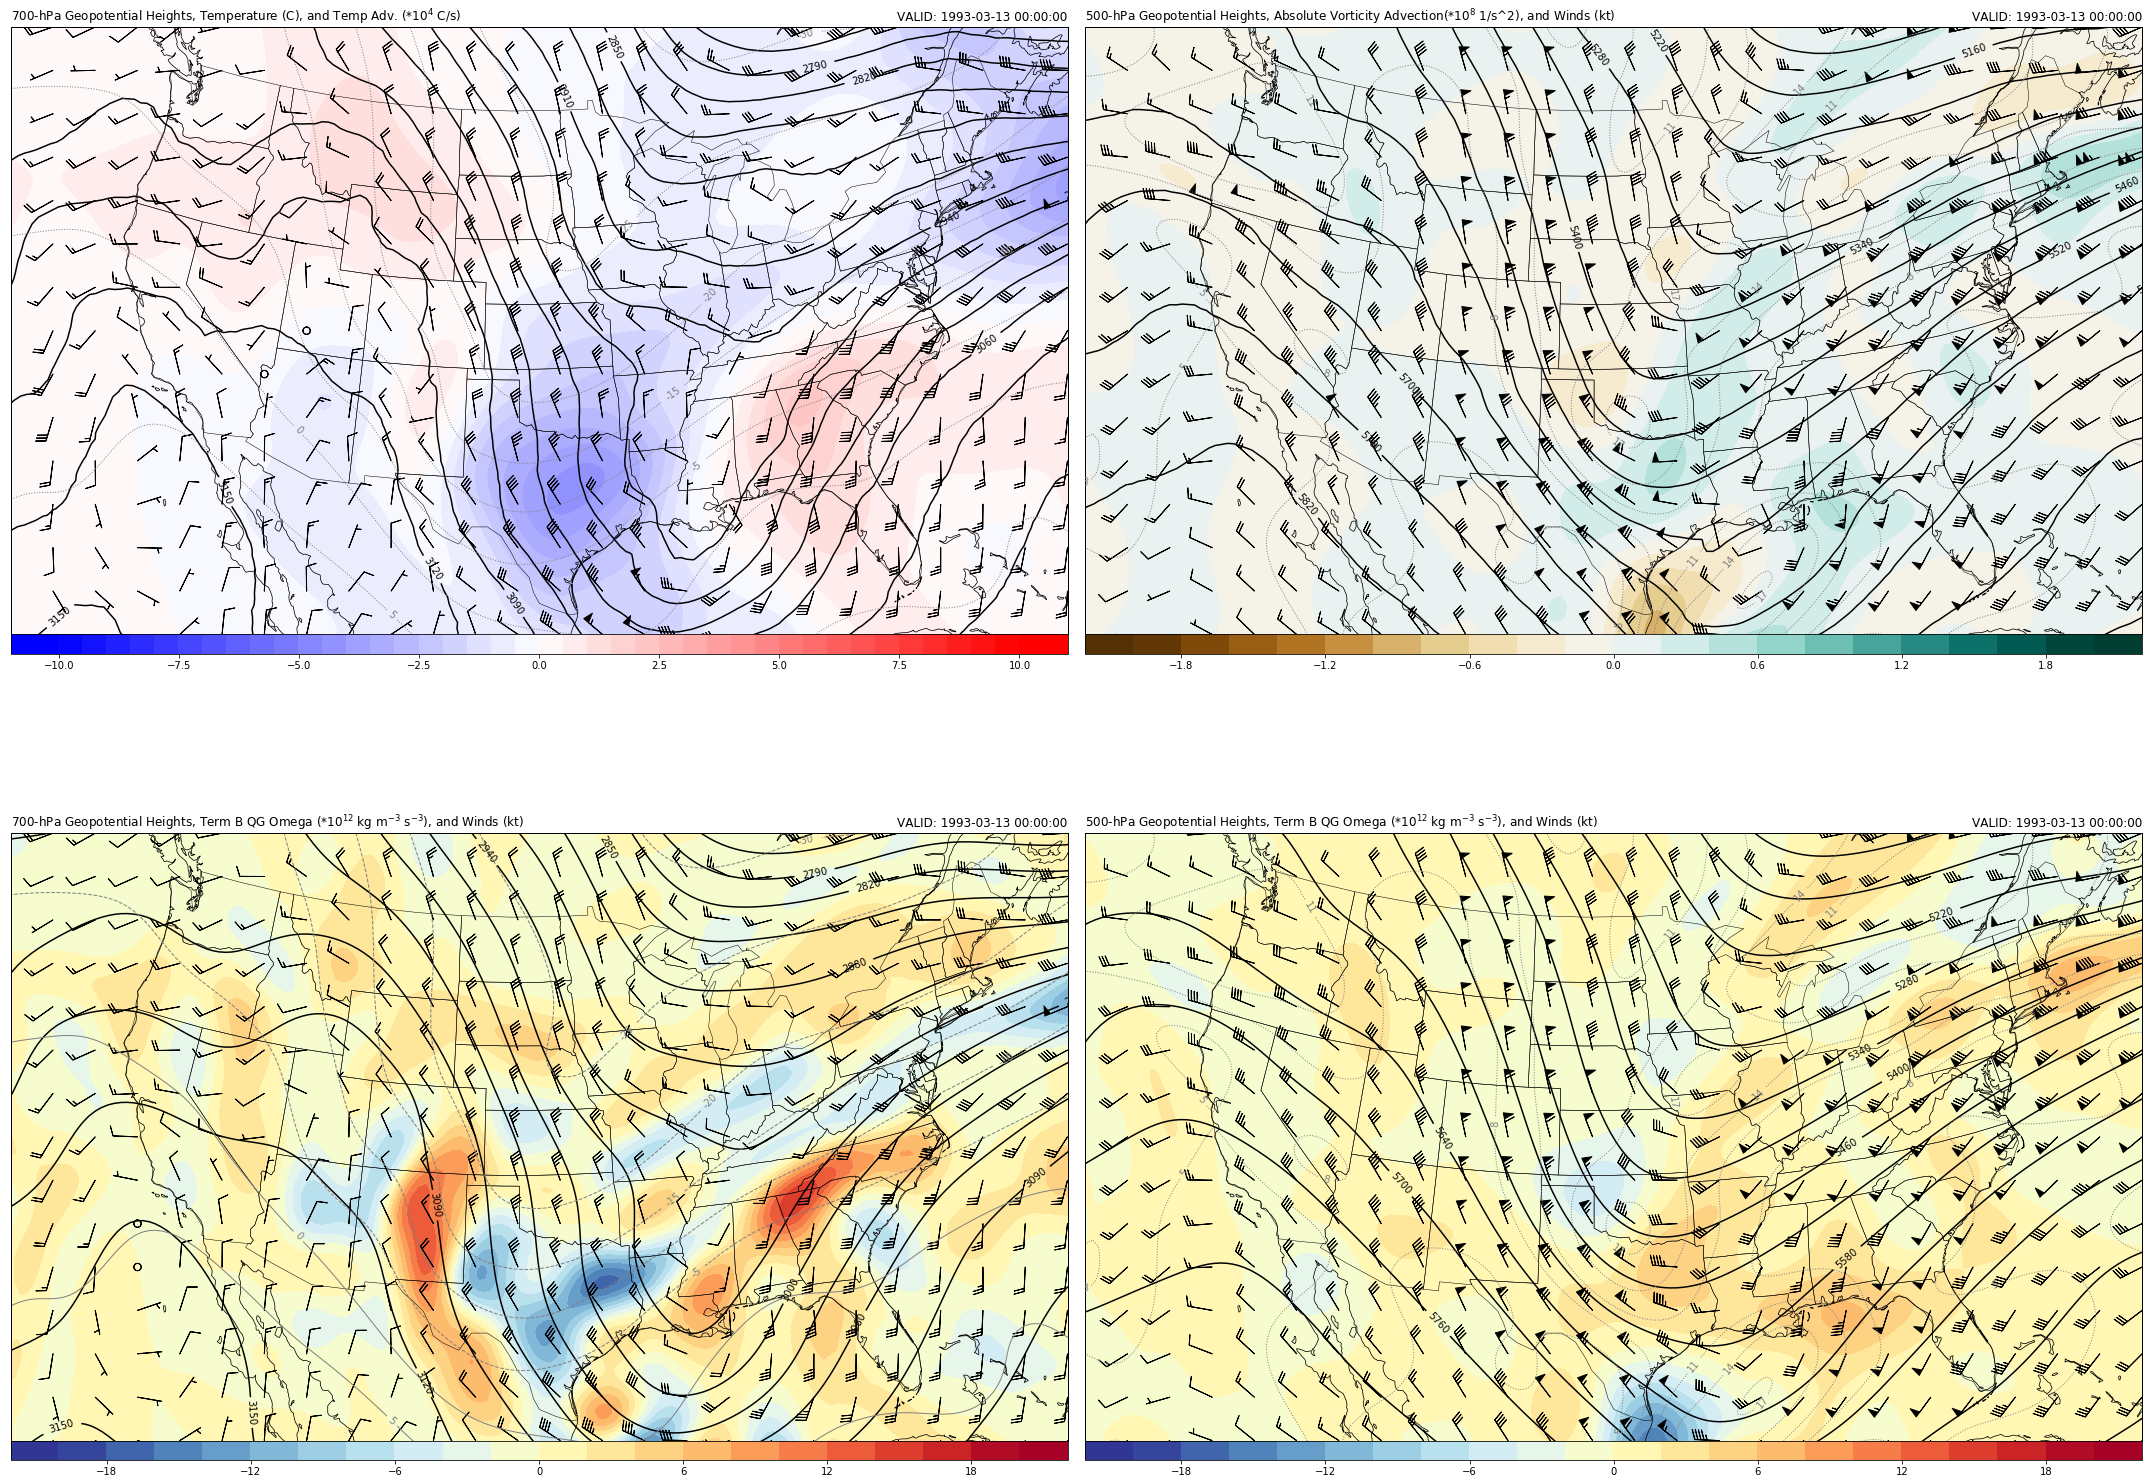

In [32]:
# Set figure size
fig=plt.figure(1, figsize=(30.,24.))

# Upper-Left Panel
ax=plt.subplot(221, projection=plotproj)
ax.set_extent([-125., -73, 25., 50.],ccrs.PlateCarree())
ax.coastlines('50m', linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Contour #1
cs = ax.contour(lons, lats, hght_700, clev_hght_700,colors='k',
                linewidths=1.5, linestyles='solid', transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Contour #2
cs2 = ax.contour(lons, lats, tmpc_700s, clev_tmpc_700, colors='grey',
                linewidths=1.0, linestyles='dotted', transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d',
           rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(lons, lats, tadv_700*10**4, np.arange(-10,10.1,0.5),
                 cmap=plt.cm.bwr, extend='both', transform=dataproj)
plt.colorbar(cf, orientation='horizontal', pad=0.0, aspect=50, extendrect=True)

# Vector
ax.barbs(lons, lats, uwnd_700.to('kts').m, vwnd_700.to('kts').m,
         regrid_shape=15, transform=dataproj)

# Titles
plt.title(r'700-hPa Geopotential Heights, Temperature (C), and Temp Adv. '
          '($*10^4$ C/s)',loc='left')
plt.title('VALID: %s' %(vtime),loc='right')



# Upper-Right Panel
ax=plt.subplot(222, projection=plotproj)
ax.set_extent([-125., -73, 25., 50.],ccrs.PlateCarree())
ax.coastlines('50m', linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Contour #1
clev500 = np.arange(0,7000,60)
cs = ax.contour(lons, lats, hght_500, clev500, colors='k',
                linewidths=1.5, linestyles='solid', transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Contour #2
cs2 = ax.contour(lons, lats, avor_500*10**5, np.arange(-40, 50, 3),colors='grey',
                linewidths=1.0, linestyles='dotted', transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d',
           rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(lons, lats, vortadv_500*10**8, np.arange(-2, 2.2, 0.2),
                 cmap=plt.cm.BrBG, extend='both', transform=dataproj)
plt.colorbar(cf, orientation='horizontal', pad=0.0, aspect=50, extendrect=True)

# Vector
ax.barbs(lons, lats, uwnd_500.to('kts').m, vwnd_500.to('kts').m,
         regrid_shape=15, transform=dataproj)

# Titles
plt.title(r'500-hPa Geopotential Heights, Absolute Vorticity Advection'
          '($*10^{8}$ 1/s^2), and Winds (kt)',loc='left')
plt.title('VALID: %s' %(vtime),loc='right')



# Lower-Left Panel
ax=plt.subplot(223, projection=plotproj)
ax.set_extent([-125., -73, 25., 50.],ccrs.PlateCarree())
ax.coastlines('50m', linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Contour #1
cs = ax.contour(lons, lats, hght_700s, clev_hght_700, colors='k',
                linewidths=1.5, linestyles='solid', transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Contour #2
cs2 = ax.contour(lons, lats, tmpc_700s, clev_tmpc_700, colors='grey',
                linewidths=1.0, transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d',
           rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(lons, lats, term_B*10**12, clev_omega,
                 cmap=plt.cm.RdYlBu_r, extend='both', transform=dataproj)
plt.colorbar(cf, orientation='horizontal', pad=0.0, aspect=50, extendrect=True)

# Vector
ax.barbs(lons, lats, uwnd_700s.to('kts').m, vwnd_700s.to('kts').m,
         regrid_shape=15, transform=dataproj)

# Titles
plt.title(r'700-hPa Geopotential Heights, Term B QG Omega '
          '($*10^{12}$ kg m$^{-3}$ s$^{-3}$), and Winds (kt)',loc='left')
plt.title('VALID: %s' %(vtime),loc='right')



# # Lower-Right Panel
ax=plt.subplot(224, projection=plotproj)
ax.set_extent([-125., -73, 25., 50.],ccrs.PlateCarree())
ax.coastlines('50m', linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Contour #1
cs = ax.contour(lons, lats, hght_500s, clev500, colors='k',
                linewidths=1.5, linestyles='solid', transform=dataproj)
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=3, fmt='%i',
           rightside_up=True, use_clabeltext=True)

# Contour #2
cs2 = ax.contour(lons, lats, avor_500*10**5, np.arange(-40, 50, 3), colors='grey',
                linewidths=1.0, linestyles='dotted', transform=dataproj)
plt.clabel(cs2, fontsize=10, inline=1, inline_spacing=3, fmt='%d',
           rightside_up=True, use_clabeltext=True)

# Colorfill
cf = ax.contourf(lons, lats, term_A*10**12, clev_omega,
                 cmap=plt.cm.RdYlBu_r, extend='both', transform=dataproj)
plt.colorbar(cf, orientation='horizontal', pad=0.0, aspect=50, extendrect=True)

# Vector
ax.barbs(lons, lats, uwnd_500s.to('kt').m, vwnd_500s.to('kt').m,
         regrid_shape=15, transform=dataproj)

# Titles
plt.title(r'500-hPa Geopotential Heights, Term B QG Omega '
          '($*10^{12}$ kg m$^{-3}$ s$^{-3}$), and Winds (kt)',loc='left')
plt.title('VALID: %s' %(vtime),loc='right')

plt.tight_layout()
plt.show()

### Exercise

Plot the combined QG Omega forcing terms (term_A + term_B) in a single panel

BONUS: Compute a difference map of Term A and Term B and plot

#### Solution

In [37]:
# %load solutions/qg_omega_total_fig.py
